In [2]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker



# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [1]:
session = fastf1.get_session(2023,10,'R')
session.load()

NameError: name 'fastf1' is not defined

### Pre defined

In [194]:
compound_color = {'HARD': 'F0F0EC', 
                  'INTERMEDIATE': '43B02A', 
                  'MEDIUM': 'FFD12E', 
                  'SOFT': 'DA291C', 
                  'TEST-UNKNOWN': '434649', 
                  'UNKNOWN': '00FFFF', 
                  'WET': '0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']

In [195]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

In [196]:
def max_lap(laps):
    grouped = laps.groupby("Driver")
    count_values = grouped['LapNumber'].count()
    return count_values.max()

In [197]:
laps = session.laps
drivers = session.drivers[:10]
all_laps = laps
all_laps['LapStartTimeS'] = all_laps["LapStartTime"].dt.total_seconds()
all_laps['DeltaTime'] = 0

In [198]:
# laps['LapTimeMinute'] = pd.to_timedelta(laps['LapTime'])
# laps['LapTimeMinute'] = laps['LapTimeMinute'].apply(lambda x: f"{x.seconds//60:02d}:{x.seconds%60:02d}.{x.microseconds//1000:03d}")

In [199]:
winner = session.results.loc[session.results["Position"]==1,"DriverNumber"].values[0]
winner

'44'

In [200]:
delta_time = all_laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapStartTimeS","DeltaTime"]]
for i in drivers:
    a = delta_time.loc[delta_time["DriverNumber"] == i,["LapStartTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == winner,["LapStartTimeS"]].reset_index()
    length = len(delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"])
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = a.loc[:, "LapStartTimeS"].values[:length]

### Race Results 

In [201]:
results_race = session.results[["DriverNumber","BroadcastName","Points","Position","GridPosition"]]
results_race["PositionGained"] = results_race["GridPosition"] - results_race["Position"]
results_race[["DriverNumber","BroadcastName","Points","Position","PositionGained"]]


C:\Users\GTR\AppData\Local\Temp\ipykernel_21412\2902143071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_race["PositionGained"] = results_race["GridPosition"] - results_race["Position"]


,DriverNumber,BroadcastName,Points,Position,PositionGained
44,44,L HAMILTON,25.0,1.0,9.0
33,33,M VERSTAPPEN,18.0,2.0,0.0
77,77,V BOTTAS,15.0,3.0,-2.0
11,11,S PEREZ,13.0,4.0,0.0
16,16,C LECLERC,10.0,5.0,1.0
55,55,C SAINZ,8.0,6.0,-3.0
10,10,P GASLY,6.0,7.0,0.0
31,31,E OCON,4.0,8.0,0.0
14,14,F ALONSO,2.0,9.0,3.0
4,4,L NORRIS,1.0,10.0,-5.0


### Gap to race winner graph

In [202]:
max_lap(laps)

71

In [203]:
# laps.loc[(laps["TrackStatus"]!='1'),["LapNumber"]].max()
delta_time["DriverNumber"]==i,["LapNumber"]

(0       False
 1       False
 2       False
 3       False
 4       False
         ...  
 1355    False
 1356    False
 1357    False
 1358    False
 1359    False
 Name: DriverNumber, Length: 1360, dtype: bool,
 ['LapNumber'])

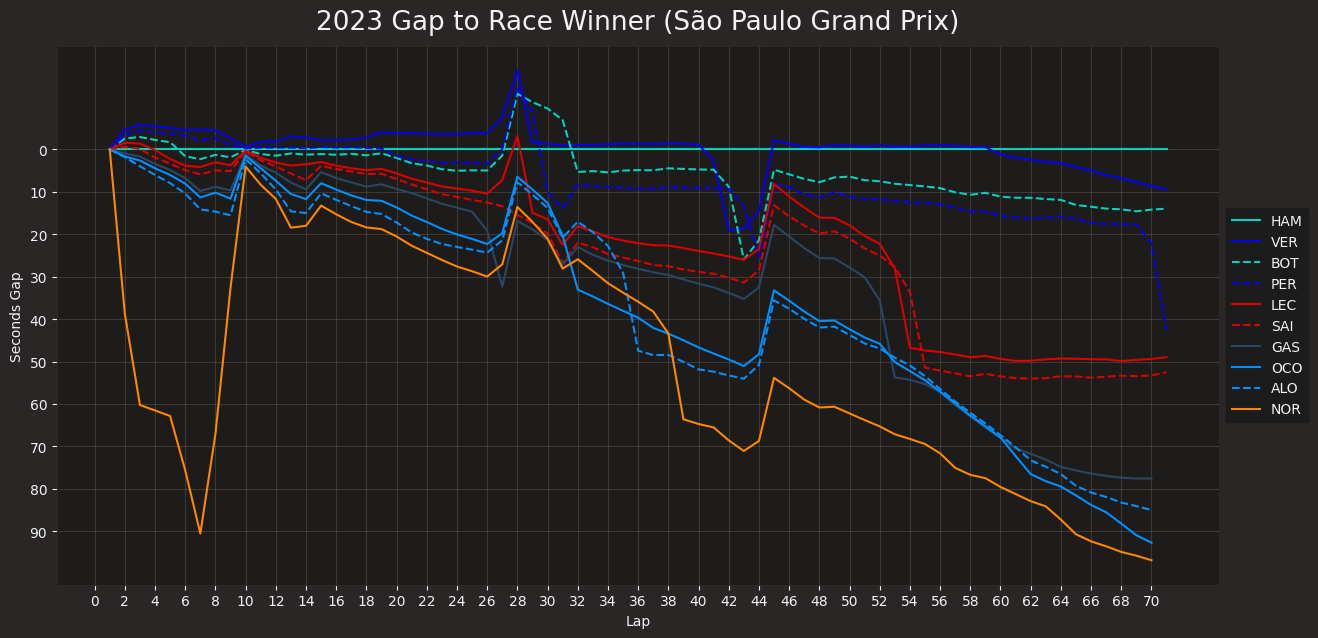

In [204]:
plt.figure(figsize=(15, 7))
color_picked = []
max_gap = int(delta_time["DeltaTime"].max())

# Adding the yellow zone from Lap 32 to Lap 38
# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

for i in drivers[:10]:
    x = delta_time.loc[delta_time["DriverNumber"]==i,["LapNumber"]]
    y = delta_time.loc[delta_time["DriverNumber"]==i,["DeltaTime"]]
    
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.plot(x, y, color=team_color, linestyle='dashed', label=driver_name)
    else:    
        plt.plot(x, y, color=team_color, linestyle='solid', label=driver_name)
        color_picked.append(team_color)

# Customize the plot
plt.title('2023 Gap to Race Winner ('+session.event["EventName"]+')')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
labels = []
# for i in range(max_lap(laps)+1):
#     if (i % 10 != 0):
#         labels.append()
#     else:
#         labels.append(i)

plt.xticks(range(0, max_lap(laps)+1, 2))

plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()


# Hide tick labels for minor ticks

# Add grid
plt.grid(True, alpha=0.2)



# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.savefig('Graphes/Race/GapRaceWinner.png', dpi=300)
plt.show()



### tires Strategy

In [205]:
drivers = session.drivers
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

We need to find the stint length and compound used
for every stint by every driver.
We do this by first grouping the laps by the driver,
the stint number, and the compound.
And then counting the number of laps in each group.



In [206]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.rename(columns={"LapNumber": "StintLength"})

The number in the LapNumber column now stands for the number of observations
in that group aka the stint length.



Now we can plot the strategies for each driver



In [207]:
# driver_stints = stints.loc[stints["Driver"] == 'VER']
# driver_stints.loc[driver_stints["Stint"]==1,"Stint"] = 2
# driver_stints

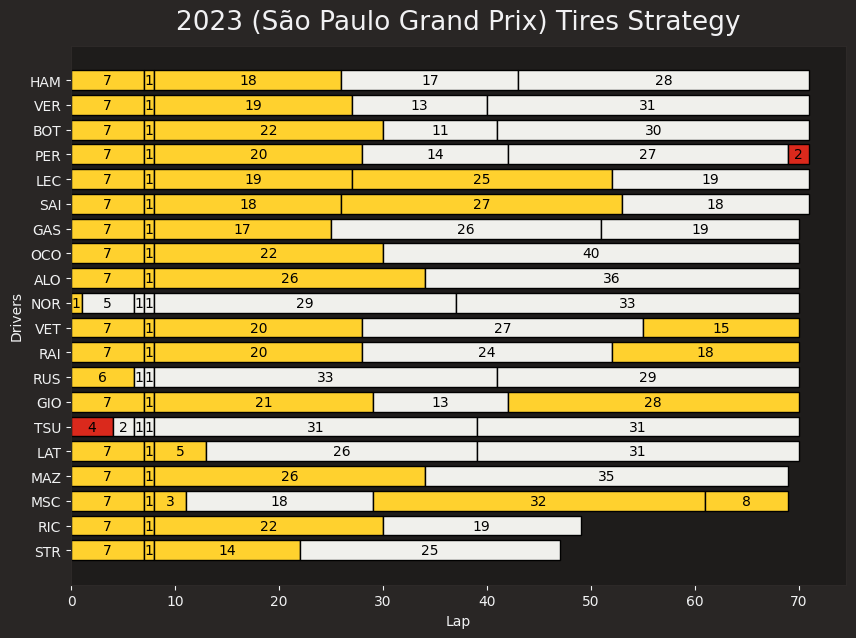

In [208]:
fig, ax = plt.subplots(figsize=(10, 7))

for driver in drivers_abr:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color='#'+compound_color[row["Compound"]],
            edgecolor="black",
            fill=True
        )

        # Add the value over the bar
        plt.text(
            x=previous_stint_end + row["StintLength"] / 2,
            y=driver,
            s=str(row["StintLength"]),
            ha='center',
            va='center',
            color='black'  # Set text color to black
        )

        previous_stint_end += row["StintLength"]

# Customize the plot
plt.title('2023 (' + session.event["EventName"] + ') Tires Strategy')
plt.xlabel('Lap')
plt.ylabel('Drivers')
# plt.xticks(range(0, max_lap(laps), 5))
# plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()

# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

plt.savefig('Graphes/Race/Tires_Strategy.png', dpi=300)
plt.show()



### Position on race

In [209]:
drivers = session.drivers

In [210]:
# position_drivers = laps.loc[laps["LapNumber"] == 2,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
# position_drivers["Position"] = list(range(1, 21))

In [211]:
first_lap = session.results
first_lap.loc[first_lap["GridPosition"] == 0,["GridPosition"]] = 20


In [212]:
first_lap = session.results[["DriverNumber","GridPosition"]].sort_values(by='GridPosition')
first_lap["Position"] = list(range(1, 21))

In [213]:
position_drivers = pd.merge( laps.loc[laps["LapNumber"] == 1,["DriverNumber","Driver","LapNumber","LapStartTime"]].reset_index(drop = True),first_lap[["DriverNumber","Position"]], on='DriverNumber', how='inner').sort_values(by = 'Position')

In [214]:
drivers

['44',
 '33',
 '77',
 '11',
 '16',
 '55',
 '10',
 '31',
 '14',
 '4',
 '5',
 '7',
 '63',
 '99',
 '22',
 '6',
 '9',
 '47',
 '3',
 '18']

In [215]:
position_drivers_add = laps.loc[laps["LapNumber"] == 2,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
position_drivers_add["Position"] = list(range(1, 21))
position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)
for i in range(3,max_lap(laps)+1):
    position_drivers_add = laps.loc[laps["LapNumber"] == i,["DriverNumber","Driver","LapNumber","LapStartTime"]].sort_values(by ='LapStartTime')
    position_drivers_add["Position"] = list(range(1, len(position_drivers_add)+1))
    position_drivers = pd.concat([position_drivers, position_drivers_add], ignore_index=True)

In [216]:
drivers_abr = position_drivers.loc[position_drivers["LapNumber"]== 1,"Driver"].values

In [217]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

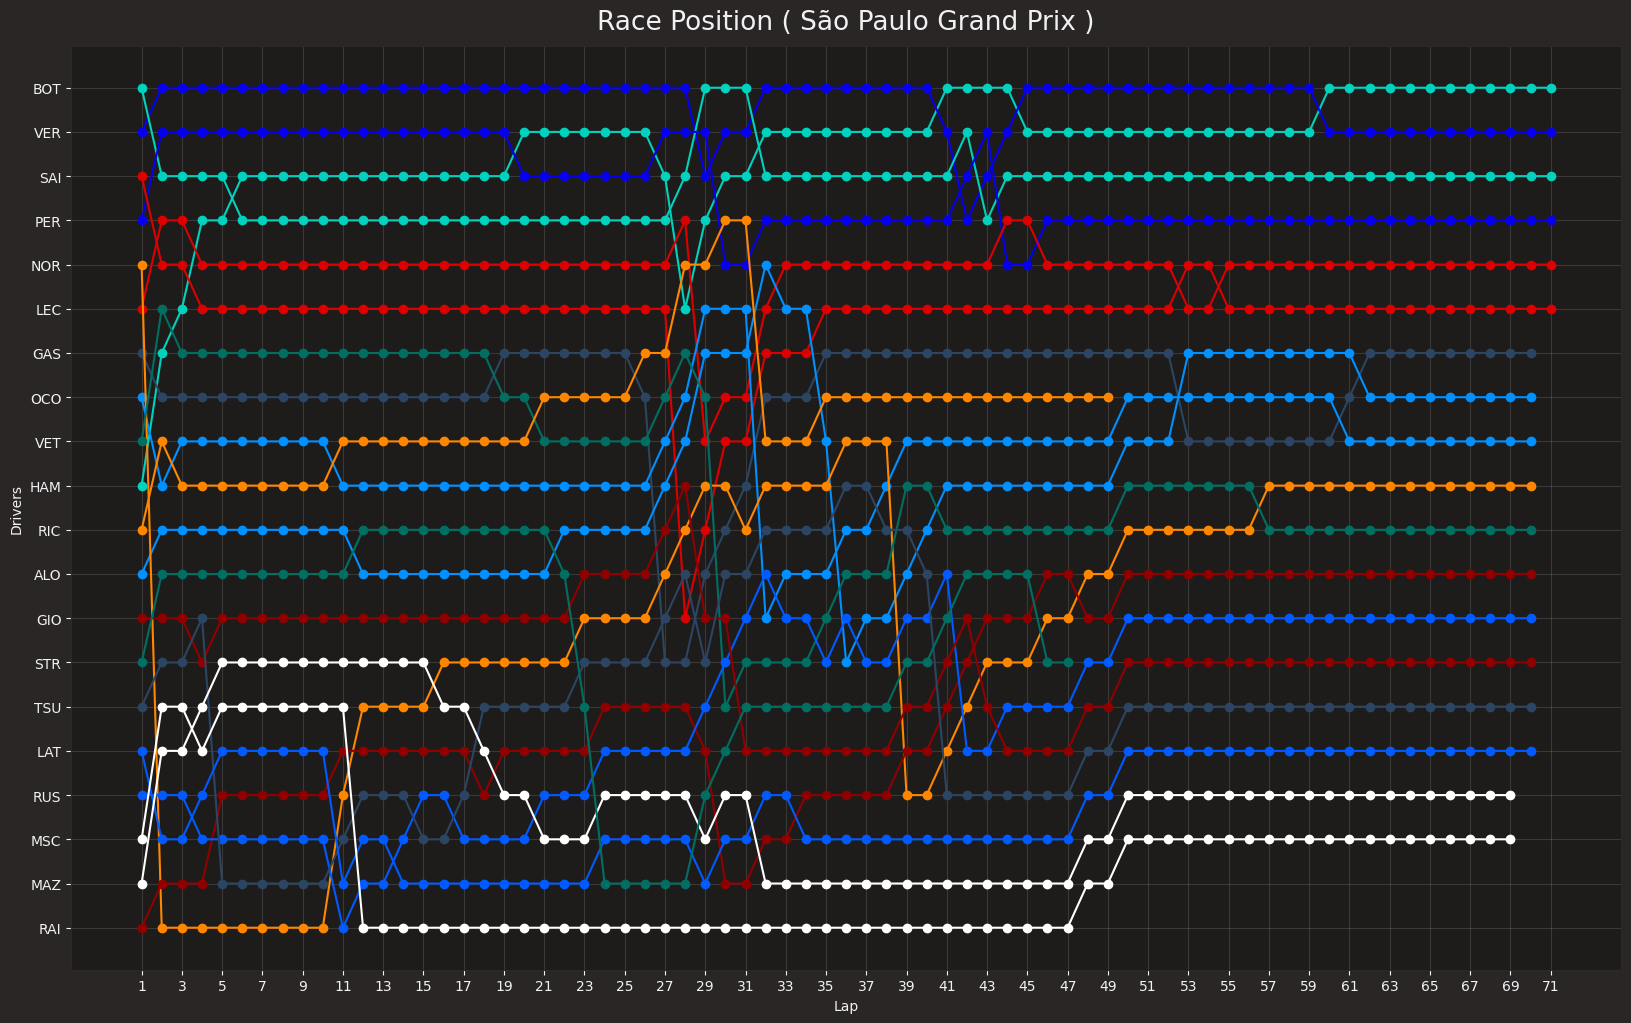

In [218]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 12))

# Plot each line with dots using a loop
for i in drivers:
    ax.plot(position_drivers.loc[position_drivers["DriverNumber"]== i,["LapNumber"]], position_drivers.loc[position_drivers["DriverNumber"]== i,["Position"]] 
            , marker='o', linestyle='-', color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"]) ,label=position_drivers.loc[(position_drivers["DriverNumber"]== i)&(position_drivers["LapNumber"]== 1),["Driver"]])

plt.title('Race Position ( '+session.event["EventName"]+' )')
plt.xlabel('Lap')
plt.ylabel('Drivers')
plt.xticks(range(1, max_lap(laps)+1, 2))
plt.yticks(range(1, len(drivers) + 1),drivers_abr)
plt.gca().invert_yaxis()


# Add a legend
plt.grid(True, alpha=0.2)
# ax.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('Graphes/Race/RacePosition.png', dpi=300)
# Show the plot
plt.show()


### Race Pace 

In [219]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [220]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

intr_qr

1.9525000000000006

In [221]:
laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [222]:
results = session.results
drivers_to_visualize = results['Abbreviation'][:10]
drivers= results['Abbreviation']

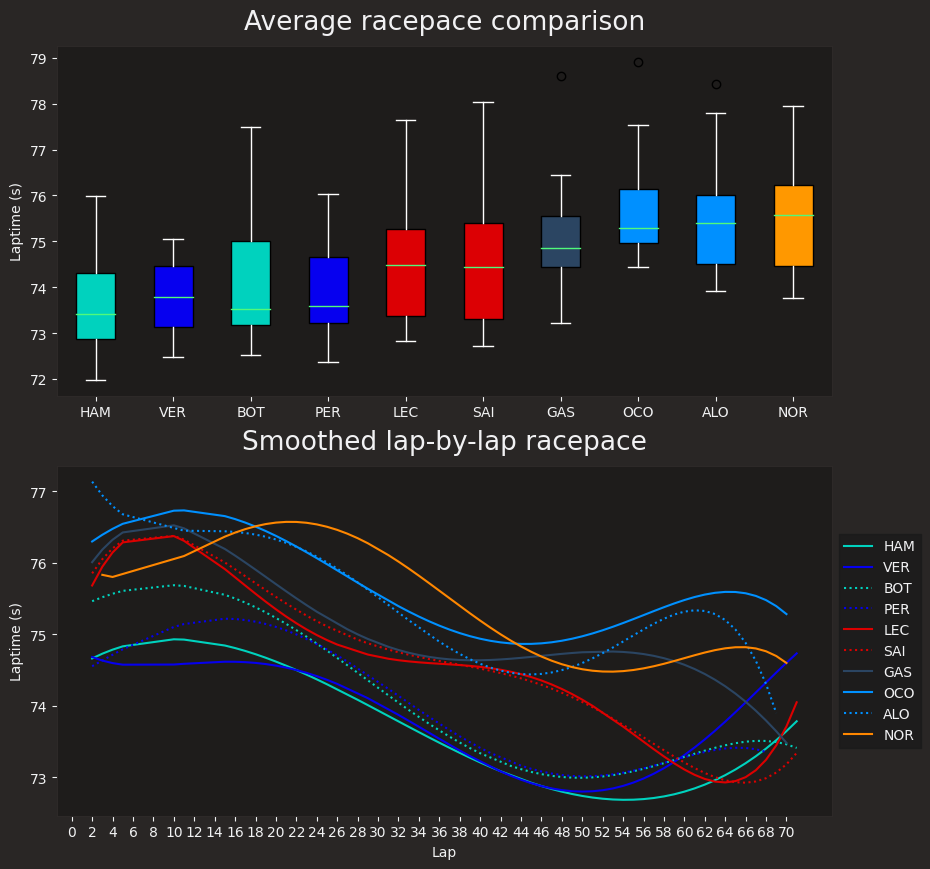

In [266]:
visualized_teams = []

fig, ax = plt.subplots(2, figsize=[10, 10])

##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

# Create a list of colors for each boxplot

# Create the boxplot with custom colors
boxplot = ax[0].boxplot(laptimes, labels=drivers_to_visualize, patch_artist=True)

# Set the colors for each boxplot
for box, color in zip(boxplot['boxes'], '#'+session.results["TeamColor"]):
    box.set(facecolor=color)  # Set the face color of the box

# Set the line color to white
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='white')
    cap.set(color='white')
    
# Set the title and labels for the boxplot
ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)')



# ##############################
# #
# # Lap-by-lap racepace comparison
# #
# ##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=fastf1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # ax[1].set_xtrick(range(0,55),2)

    # Generate legend
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

    plt.xticks(range(0,session.laps["LapNumber"].max(), 2))
# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)
plt.savefig('Graphes/Race/racepace_comparison.png', dpi=300)

In [228]:
session.laps["LapNumber"].max()

71

### Top Speed

In [325]:
from statistics import mean 
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []
df_top_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        Avg_Top_Speed = []
        for j in range(1,laps["LapNumber"].max()):
            print(j)
            max_speed = laps.loc[laps["LapNumber"]== j].pick_driver(i).get_car_data()
            Avg_Top_Speed.append(max_speed.loc[max_speed['Speed'].idxmax(),"Speed"])
        Top_Speed = mean(Avg_Top_Speed)
        print(Top_Speed)
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        top_speed_list.append(Top_Speed)
        color_list.append(TeamColor)
df_top_speed["DriverNumber"] = driver_list
df_top_speed["Driver"] = DriverAB_list
df_top_speed["TopSpeed"] = top_speed_list
df_top_speed["Color"] = color_list
df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False)


1


ValueError: Cannot slice telemetry because self contains no driver number!

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime
0,2021-11-14 17:05:30.820,11716,325,8,100,False,1,car,0 days 00:00:00.052000,0 days 01:04:30.810000
1,2021-11-14 17:05:31.060,11716,325,8,100,False,1,car,0 days 00:00:00.292000,0 days 01:04:31.050000
2,2021-11-14 17:05:31.300,11697,324,8,100,False,1,car,0 days 00:00:00.532000,0 days 01:04:31.290000
3,2021-11-14 17:05:31.540,11792,328,8,100,False,0,car,0 days 00:00:00.772000,0 days 01:04:31.530000
4,2021-11-14 17:05:31.780,11735,327,8,100,False,2,car,0 days 00:00:01.012000,0 days 01:04:31.770000
...,...,...,...,...,...,...,...,...,...,...
304,2021-11-14 17:06:43.860,11621,323,8,100,False,12,car,0 days 00:01:13.092000,0 days 01:05:43.850000
305,2021-11-14 17:06:44.100,11649,323,8,100,False,12,car,0 days 00:01:13.332000,0 days 01:05:44.090000
306,2021-11-14 17:06:44.340,11624,324,8,100,False,12,car,0 days 00:01:13.572000,0 days 01:05:44.330000
307,2021-11-14 17:06:44.580,11697,325,8,100,False,12,car,0 days 00:01:13.812000,0 days 01:05:44.570000


In [347]:
for j in range(1,20):
    a = laps.loc[(laps["LapNumber"]== j)&(laps["DriverNumber"]== '44')].get_car_data()

ValueError: Cannot slice telemetry because self contains no driver number!

In [319]:
# df_top_speed["TopSpeed"].min()

In [314]:
# Avg_Top_Speed = []
# for j in laps["LapNumber"].max():
#     max_speed = laps.loc[laps["LapNumber"]== j].pick_driver(i).get_car_data()
#     Avg_Top_Speed = Avg_Top_Speed.append(max_speed.loc[max_speed['Speed'].idxmax(),"Speed"])


# Top_Speed = Avg_Top_Speed.mean()
# Driver = session.get_driver(i)[["DriverNumber"]].values[0]
# DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
# TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
# driver_list.append(Driver)
# DriverAB_list.append(DriverAB)
# top_speed_list.append(Top_Speed)
# color_list.append(TeamColor)
    

In [315]:
min_speed_value = int(df_top_speed["TopSpeed"].min())
max_speed_value = int(df_top_speed["TopSpeed"].max())

KeyError: 'TopSpeed'

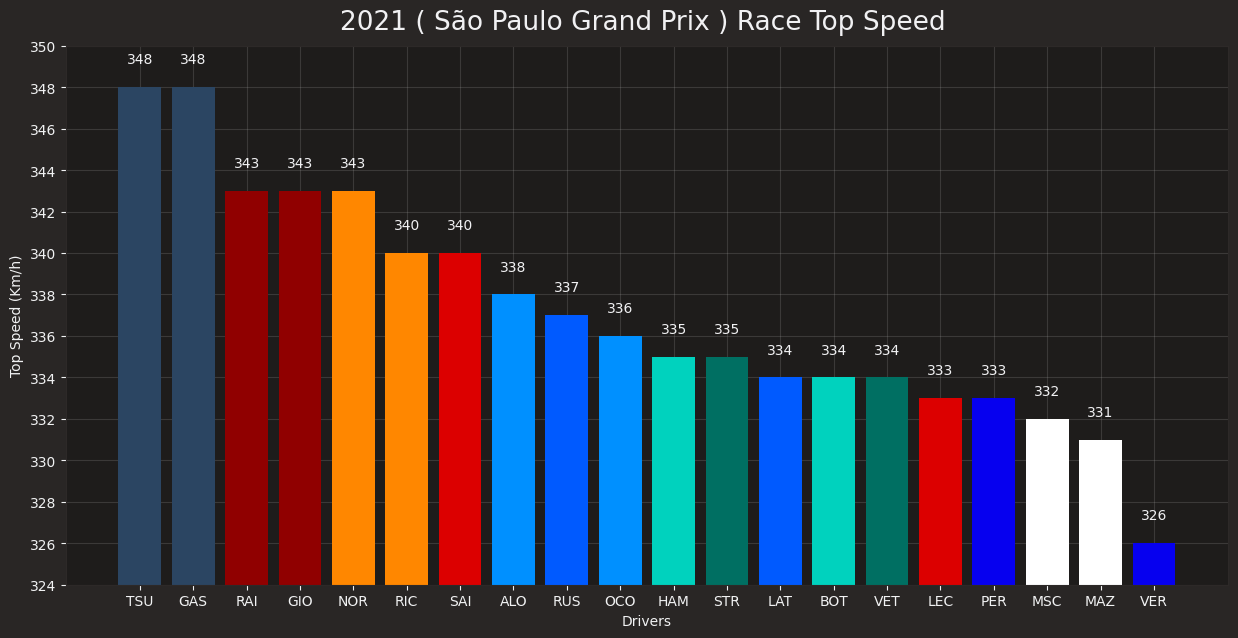

In [ ]:
plt.figure(figsize=(15, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Top Speed (Km/h)')
plt.title('2021 ( '+session.event["EventName"]+' ) Race Top Speed ')
plt.yticks(range(min_speed_value-4, max_speed_value+4, 2))
plt.ylim(min_speed_value-2, max_speed_value+2)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+1, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(True, alpha=0.2)
# Display the plot
plt.show()

### average Speed

In [ ]:
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []
df_avg_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())
        Driver = session.get_driver(i)[["DriverNumber"]].values[0]
        DriverAB = session.get_driver(i)[["Abbreviation"]].values[0]
        TeamColor = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
        driver_list.append(Driver)
        DriverAB_list.append(DriverAB)
        avg_speed_list.append(avg_Speed)
        color_list.append(TeamColor)
df_avg_speed["DriverNumber"] = driver_list
df_avg_speed["Driver"] = DriverAB_list
df_avg_speed["AvgSpeed"] = avg_speed_list
df_avg_speed["Color"] = color_list
df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False)


c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` or `Driver.FirstName` instead.
  warnings.warn(
c:\Users\GTR\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:2659: FutureWarning: The `Driver.name` property is deprecated and will beremoved in a future version.
Use `Driver['FirstName']` 

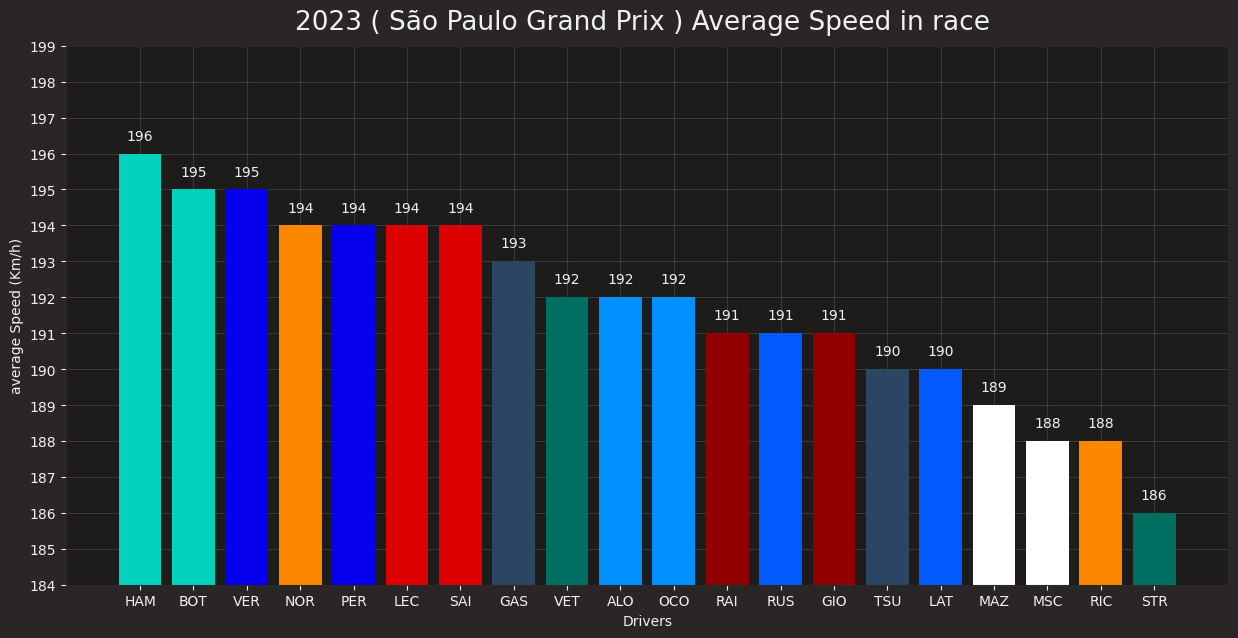

In [ ]:
plt.figure(figsize=(15, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) Average Speed in race ')
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(True, alpha=0.2)

# Display the plot
plt.show()

In [ ]:
laps.pick_driver(33).get_car_data()

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime
0,2021-11-14 17:04:10.579,10908,297,8,100,False,1,car,0 days 00:00:00.199000,0 days 01:03:10.569000
1,2021-11-14 17:04:10.820,10591,296,8,100,False,1,car,0 days 00:00:00.440000,0 days 01:03:10.810000
2,2021-11-14 17:04:11.060,10659,294,8,100,False,1,car,0 days 00:00:00.680000,0 days 01:03:11.050000
3,2021-11-14 17:04:11.300,10660,293,8,100,False,1,car,0 days 00:00:00.920000,0 days 01:03:11.290000
4,2021-11-14 17:04:11.540,10610,292,8,100,False,1,car,0 days 00:00:01.160000,0 days 01:03:11.530000
...,...,...,...,...,...,...,...,...,...,...
22720,2021-11-14 18:35:24.235,10937,301,8,100,False,0,car,0 days 01:31:13.855000,0 days 02:34:24.225000
22721,2021-11-14 18:35:24.475,10985,302,8,100,False,0,car,0 days 01:31:14.095000,0 days 02:34:24.465000
22722,2021-11-14 18:35:24.715,10919,302,8,100,False,0,car,0 days 01:31:14.335000,0 days 02:34:24.705000
22723,2021-11-14 18:35:24.955,10910,303,8,100,False,0,car,0 days 01:31:14.575000,0 days 02:34:24.945000
